In [1]:
import re
import numpy as np
import random
import tensorflow as tf
from tensorflow import keras
from word_seg_model import BiLSTMCRF
import tensorflow.keras.backend as K 
from tqdm import tqdm

In [2]:
with open('../datasets_eg/icwb2-data/training/msr_training.txt', "r", encoding="gbk") as f:
    sents = f.readlines()
sents = [line.strip().split(" ") for line in sents]  # 词之间以空格隔开
sents = [[w for w in sent if w] for sent in sents]  # 去掉空字符串
random.shuffle(sents)

chars = {} # 统计字表
for sent in sents:
    for c in sent:
        chars[c] = chars.get(c, 0) + 1

In [3]:
min_count = 2 # 过滤低频字
chars = {i:j for i,j in chars.items() if j >= min_count} # 过滤低频字

id2char = {i+2:j for i,j in enumerate(chars)} # id到字的映射, 0:pad, 1:unk
id2char[0] = "pad"
id2char[1] = "unk"
char2id = {j:i for i,j in id2char.items()} # 字到id的映射

id2tag = {0:'s', 1:'b', 2:'m', 3:'e'} # 标签（sbme）与id之间的映射
tag2id = {j:i for i,j in id2tag.items()}

train_sents = sents[:-5000] # 留下5000个句子做验证，剩下的都用来训练
valid_sents = sents[-5000:]

In [4]:
del sents
del chars

In [5]:
def padding(X, pad):
    maxlen = max([len(x) for x in X]) # 找出最大字数
    X = [x + [pad] * (maxlen-len(x)) for x in X] # 不足则补pad
    return X

In [6]:
batch_size = 64
def data_generator(data): # 定义数据生成器
    while True:
        X,Y = [],[]
        for i,s in enumerate(data): # 遍历每个句子
            # sx:字id; sy:字标签
            sx,sy = [],[]
            for w in s: # 遍历句子中的每个词
                sx.extend([char2id.get(c, 1) for c in w]) # 遍历词中的每个字
                if len(w) == 1:
                    sy.append(0) # 单字词的标签
                elif len(w) == 2:
                    sy.extend([1,3]) # 双字词的标签
                else:
                    sy.extend([1] + [2]*(len(w)-2) + [3]) # 多于两字的词的标签
            X.append(sx)
            Y.append(sy)
            if len(X) == batch_size or i == len(train_sents)-1: # 如果达到一个batch
                X = padding(X, pad=0) # 不足则补零
                Y = padding(Y, pad=4) # 不足则补第五个标签
#                 print(len(X[0]), len(Y[0]))
                yield tf.cast(X, tf.int32), tf.one_hot(Y, 5)
                X,Y = [],[]

In [7]:
embedding_size = 128
vocab_size = len(char2id)
nlabels = len(tag2id) + 1
num_layers = 3

In [8]:
bilstmcrf = BiLSTMCRF(vocab_size, embedding_size, nlabels,  num_layers)

In [9]:
bilstmcrf.model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 128)         5984000   
_________________________________________________________________
bidirectional (Bidirectional (None, None, 256)         263168    
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 256)         394240    
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 256)         394240    
_________________________________________________________________
dense (Dense)                (None, None, 5)           1285      
_________________________________________________________________
crf (CRF)                    (None, None, 5)           16    

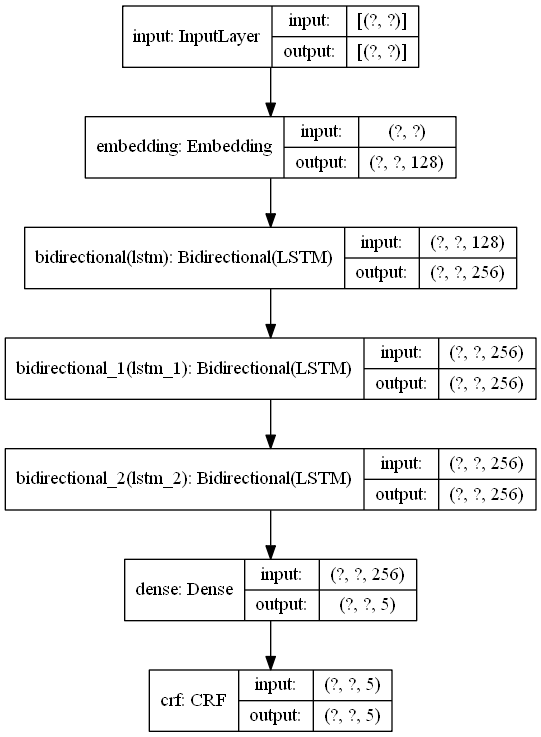

In [10]:
keras.utils.plot_model(bilstmcrf.model, "../model_img/word_seg_bilstmcrf.png", 
                       show_layer_names=True, show_shapes=True)

In [11]:
# a = sorted(d.items(), key=lambda x: x[1], reverse=True) 字典按值排序

def max_in_dict(d): # 定义一个求字典中最大值的函数
    key, value = "", -1e-9
    for i,j in d.items():
        if j > value:
            key,value = i,j
    return key,value

In [12]:
def viterbi(nodes, trans): # viterbi算法，跟前面的HMM一致
    # nodes: dict in list, key:sbme, value:proba
    paths = nodes[0] # 初始化起始路径
    for l in range(1, len(nodes)): # 遍历后面的节点
        paths_old, paths = paths, {}
        for n, ns in nodes[l].items(): # 当前时刻的所有节点
            max_path, max_score = '', -1e10
            for p, ps in paths_old.items(): # 截止至前一时刻的最优路径集合
                # ns: 当前节点的分数
                # ps: 截止至前一时刻最优路径的分数
                # tran: 转移概率
                score = ns + ps + trans[p[-1] + n] # 计算新分数
                if score > max_score: # 如果新分数大于已有的最大分
                    max_path, max_score = p + n, score # 更新路径
            paths[max_path] = max_score # 储存到当前时刻所有节点的最优路径
    return max_in_dict(paths)

In [13]:
def cut(s, model, trans): # 分词函数，也跟前面的HMM基本一致
    if not s: # 空字符直接返回
        return []
    # 字序列转化为id序列。注意，经过我们前面对语料的预处理，字符集是没有空格的，
    # 所以这里简单将空格的id跟句号的id等同起来
    sent_ids = np.array([[char2id.get(c, 0) if c != ' ' else char2id['。'] for c in s]])
    probas = model.predict(sent_ids)[0] # 模型预测, [seq_len, num_labels]
    nodes = [dict(zip('sbme', i)) for i in probas[:, :4]] # 只取前4个,seq_len个字典，每个字典4个键值，键是标注，值是概率
    nodes[0] = {i:j for i,j in nodes[0].items() if i in 'bs'} # 首字标签只能是b或s，只保留b,s两个键
    nodes[-1] = {i:j for i,j in nodes[-1].items() if i in 'es'} # 末字标签只能是e或s，只保留e,s两个键
    tags = viterbi(nodes, trans)[0]
    result = [s[0]]
    for i,j in zip(s[1:], tags[1:]):
        if j in 'bs': # 词的开始
            result.append(i)
        else: # 接着原来的词
            result[-1] += i
    return result

In [14]:
def convert_to_dict(trans_mat, tag2id):
    # 将矩阵表示的转移概率，转化为键值表示，如"sb":0.7，表示s到b的概率为0.7
    trans = {}
    for i in 'sbme':
        for j in 'sbme':
            trans[i+j] = trans_mat[tag2id[i], tag2id[j]]
    return trans

In [18]:
# 自定义Callback类
class Evaluate(keras.callbacks.Callback):
    def __init__(self, tag2id):
        self.highest = 0.
        self.tag2id = tag2id
        
    def on_epoch_end(self, epoch, logs=None):
        trans_mat = self.model.get_weights()[-1][:4,:4] # 从训练模型中取出最新得到的转移矩阵
        # 将4*4矩阵表示的转移概率转化为字典型
        trans = convert_to_dict(trans_mat, self.tag2id)
        right = 0.
        total = 0.
        for s in random.sample(valid_sents, 100):
            result = cut(''.join(s), self.model, trans)
            total += len(set(s))
            right += len(set(s) & set(result)) # 直接将词集的交集作为正确数。该指标比较简单，
                                               # 也许会导致估计偏高。读者可以考虑自定义指标
        acc = right / total
        if acc > self.highest:
            self.highest = acc
            print("model improved")
            self.model.save_weights("../model_file/bilstmcrf_best_model.weights")
        print('val acc: {}, highest: {}, val loss: {}'.format(acc, self.highest, logs["val_loss"]))

In [ ]:
evaluator = Evaluate(tag2id) # 建立Callback类
bilstmcrf.model.fit_generator(data_generator(train_sents), steps_per_epoch=500,
                           validation_data=data_generator(valid_sents), validation_steps=200,
                           epochs=20, 
                           verbose=2, 
                           callbacks=[evaluator]
                          ) # 训练并将evaluator加入到训练过程

Epoch 1/20


W1206 03:28:23.628868  6884 def_function.py:474] 5 out of the last 17 calls to <function _make_execution_function.<locals>.distributed_function at 0x00000221CAA4D510> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/beta/tutorials/eager/tf_function#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.
W1206 03:28:41.169236  6884 def_function.py:474] 5 out of the last 18 calls to <function _make_execution_function.<locals>.distributed_function at 0x00000221CAA4D510> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option th

model improved
val acc: 0.8428196147110333, highest: 0.8428196147110333, val loss: 10.904414412975312
500/500 - 22693s - loss: 12.5794 - accuracy: 0.8642 - val_loss: 10.9044 - val_accuracy: 0.8774
Epoch 2/20
model improved
val acc: 0.862786745964316, highest: 0.862786745964316, val loss: 8.5077054977417
500/500 - 36441s - loss: 9.8735 - accuracy: 0.8771 - val_loss: 8.5077 - val_accuracy: 0.8831
Epoch 3/20
model improved
val acc: 0.862852334875894, highest: 0.862852334875894, val loss: 7.073852713108063
500/500 - 51486s - loss: 7.8866 - accuracy: 0.8866 - val_loss: 7.0739 - val_accuracy: 0.8852
Epoch 4/20


In [ ]:
text_sent = "其实在没有体验这款产品之前，上述的几个智慧屏特性给我的感觉与智能电视没有太大区别，无非就是人机交互与家居互联上有一些提升。"
trans_mat = cnncrf.model.get_weights()[-1][:4,:4] # 从训练模型中取出最新得到的转移矩阵
# 将4*4矩阵表示的转移概率转化为字典型
trans = convert_to_dict(trans_mat, tag2id)
result = cut(''.join(text_sent), cnncrf.model, trans)
print(result)

In [ ]:
trans_mat = cnncrf.model.get_weights()[-1][:4,:4] # 从训练模型中取出最新得到的转移矩阵
# 将4*4矩阵表示的转移概率转化为字典型
trans = convert_to_dict(trans_mat, tag2id)
right = 0.
total = 0.
for s in valid_sents:
    result = cut(''.join(s), cnncrf.model, trans)
    total += len(set(s))
    right += len(set(s) & set(result)) # 直接将词集的交集作为正确数。该指标比较简单，
                                       # 也许会导致估计偏高。读者可以考虑自定义指标
acc = right / total
print(acc)